In [1]:
using DataFrames, Distributions, GLM, MLBase, PyPlot, StatsBase, Random

In [2]:
using CSV, QuantileRegressions, QuantReg, RDatasets, StatsPlots, Plots   #Non version Julia 0.4.7 Packages 

# Getting the Data 

we use RDatasets package to get R data set 

--

In [3]:
cars_df = dataset("datasets", "mtcars");

In [4]:
# check column names to see if there have any unique names. Let's covert column names to lower case
originalNames = names(cars_df);
convertedNames = map(x -> lowercase(x),originalNames); 
rename!(cars_df, Symbol.(convertedNames));

In [5]:
first(cars_df,2);

## Take out outliers

In [6]:
iqr_value = iqr(cars_df[!, :mpg])
# Outlier value greater than mean + 1.5* IQR value 
cars_df = cars_df[cars_df[!,:mpg] .< (mean(cars_df[!,:mpg]) + 1.5 * iqr_value), :];
# Outlier value greater than mean + 1.5* IQR value 
cars_df[cars_df[!,:mpg] .> (mean(cars_df[!,:mpg]) - 1.5 * iqr_value), :];


# Linear Regression 

`y` is some response variable of interest, and let `x`  be a vector of features or predictors that we want to use to model the response. In linear regression, we are trying to estimate the conditional `mean` function, `E[y|x]` by a linear combination of the features.

What if we wanted to look at the effect of the model on different features more precisely. 

-----

-----

# Now let's look at percentiles

### Terminology:

#### Percenitle
A percentile is a measure at which that percentage of the total values are the same as or below that measure.
The `50th percentile` is known as the median. Percentiles are quantiles that divide a distribution into 100 equal parts.


#### Quantile
The word “quantile” comes from the word quantity. In simple terms, a quantile is where a sample is divided into equal-sized, adjacent, subgroups (that’s why it’s sometimes called a “fractile“). It can also refer to dividing a probability distribution into areas of equal probability.

The median is known as the `0.5 quantile`.


#### Quartiles
Quartiles are also quantiles; they divide the distribution into four equal parts.



## Visualizing Quantiles/Percentiles 

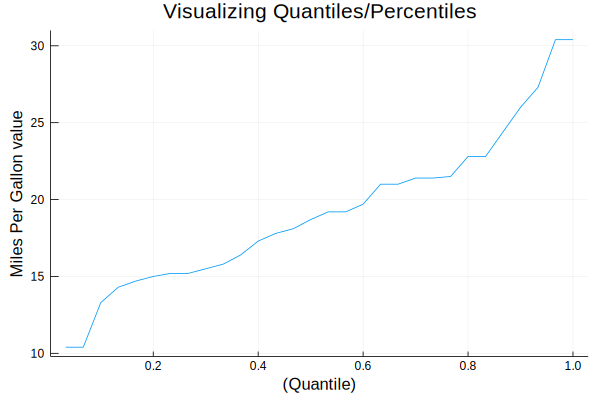

In [7]:
#Visualizing Quantiles/Percentiles 
n = length(cars_df[!,:mpg])
xaxis = collect(1:n) * (1/(n))
Plots.plot(xaxis, sort(cars_df[!,:mpg]),
           title = "Visualizing Quantiles/Percentiles", 
           ylabel = "Miles Per Gallon value",
           xlabel = "(Quantile)",
           legend = false)

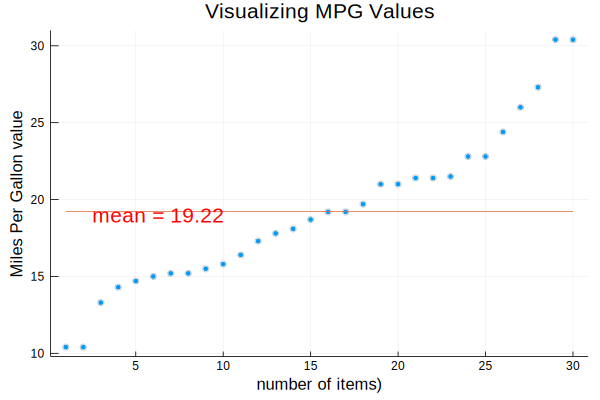

In [8]:
# See how the MPG values  look

n = length(cars_df[!,:mpg])
items = collect(1:n)
mu = round(mean(cars_df[!,:mpg]), digits=2)


Plots.plot(items, sort(cars_df[!,:mpg]), seriestype = :scatter,
           title = "Visualizing MPG Values", 
           ylabel = "Miles Per Gallon value",
           xlabel = "number of items)",
           legend = false)

Plots.plot!(items, fill(mu, n), 
            annotations = (10, 19, Plots.text("mean = $mu", :red, :right) ))

# Quantile regression 


Some helpful references:

https://www.r-bloggers.com/2019/01/quantile-regression-in-r-2/

https://github.com/pkofod/QuantileRegressions.jl/blob/master/examples/npqreg.jl

https://juliapackages.com/p/quantileregression

https://github.com/pkofod/QuantileRegressions.jl/blob/master/examples/qreg_example.jl



`Quantile regression` is a regression method for estimating these conditional quantile functions. Just as linear regression estimates the conditional mean function as a linear combination of the predictors, quantile regression estimates the conditional quantile function as a linear combination of the predictors.

Allows you to see what is happening in a localized area of your distribution. 

The big difference is quantile regression uses ABSOLUTE value of errors versus Square Error like in linear regression. Plus, we have to use mroe sophisticated optimization functions than what we use with linear regression. Quantile regression minimize objective functions and thus uses linear programming.


---
--- Example Scenario : Uber car arrival Algorithm

Example: taken from http://lineardigressions.com/episodes/2019/1/12/quantile-regression

---

Say Uber came up with a new algorithm for dispatching drivers and we are interested in how this algorithm fares in terms of wait times for consumers. A simple (linear regression) model for this is 

E[wait_time | algorithm] = a + b * `algorithm`

Where `algorithm` = 1 if the new algorithm was used to dispatch a driver, and algorithm = 0 if the previous algorithm was used. From this model, we can say that under the old algorithm, mean wait time was a, but under the new algorithm, mean wait time is a + b. So if b < 0, I would infer that my new algorithm is “doing better”. 

But is it really? What if the new algorithm improves wait times for 90% of customers by 1 min, but makes the wait times for the remaining 10% longer by 5 min? 

Overall, I would see a decrease in `mean` wait time, but things got significantly worse for a segment of my population. What if that 10% whose wait times became 5 minutes longer were already having the longest wait times to begin with? That seems like a bad situation to have, but our earlier linear regression model would not pick it up because it is looking at the overall mean/average across all of the values. 

One way to pick up such situations is to model conditional quantile functions instead. That is, instead of trying to estimate the mean of y given the features x (i.e., linear regression), let’s try to estimate a quantile of y given the features x. In our example above, instead of trying to estimate the mean wait time, we could estimate the 95th quantile wait time to catch anything going wrong out in the tails of the distribution.


Thus it becomes possible to make rigorous statements like: “the new version is faster overall for the mean, makes the fast guys much faster, but at the expense of making the slow guys a little slower.”


--


### Create the Generalized Linear Model (GLM) formula

--

In [9]:
fm = @formula(mpg ~ wt);

## Looking at 0.5 Quantile Two different Julia Methods

In [10]:
resultQR = qreg(fm, cars_df, .5) #50-ther percentile, median - QuantRegressions

StatsModels.TableRegressionModel{QuantileRegressions.QRegModel,Array{Float64,2}}

mpg ~ 1 + wt

Coefficients:
────────────────────────────────────────────────────
             Quantile  Estimate  Std.Error   t value
────────────────────────────────────────────────────
(Intercept)       0.5  33.8316    2.81723   12.0088
wt                0.5  -4.46316   0.821643  -5.43199
────────────────────────────────────────────────────

In [11]:
model50 = rq(fm, cars_df, τ=[0.50], fitmethod="br") #QuantReg package

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /Users/lhester/.juliapro/JuliaPro_v1.4.0-1/packages/QuantReg/8ffaW/src/fitqr.jl:69



mpg ~ 1 + wt, τ=0.5


Degrees of freedom: 30 total; 28 residual

──────────────────────────────────────────────────────
             Coefficient   95% CI Lower   95% CI Upper
──────────────────────────────────────────────────────
(Intercept)     33.8316        29.7312        39.3697
wt              -4.46316       -6.61742       -3.44705
──────────────────────────────────────────────────────

#### What does this resultQR mean?

A quantile regression models the relationship between x and the conditional quantiles of y rather than just the 
conditional mean of y.

We are getting a better picture of the effect of the independent variables on the dependent variable y.

We see the 0.5 quantile desired. We see the model constants for each Independent variable at the desired quantile. Similar to what we saw before in the linear regressor, the Standard Error and the t-values (measures of likely given by chance).

We say the weight, regressor/dependent variable at the qth quantile has the marginal effect of -4.46316. 
Thie estimate value estimates the change in a specified quantile q of the dependent variable y produced by a one unit change in the independent variable (weight). 

---
----

###  Let's use QuantReg to look at multiple Quantiles to help put it in context


In [12]:
models = rq(fm, cars_df, τ=[0.10, 0.25, 0.50, 0.75, 0.9])

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /Users/lhester/.juliapro/JuliaPro_v1.4.0-1/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /Users/lhester/.juliapro/JuliaPro_v1.4.0-1/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /Users/lhester/.juliapro/JuliaPro_v1.4.0-1/packages/QuantReg/8ffaW/src/fitqr.jl:69


──────────────────────────────────────────────────────
             Coefficient   95% CI Lower   95% CI Upper
──────────────────────────────────────────────────────
(Intercept)     37.5098        21.4493         41.0037
wt              -6.49485       -8.73397        -2.2747
────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Coefficient   95% CI Lower   95% CI Upper
──────────────────────────────────────────────────────
(Intercept)      35.519        24.352         41.7357
wt               -5.6872       -7.79992       -2.86098
────────────────────────────────────────────────────────────────────────────────────────────────────────────
             Coefficient   95% CI Lower   95% CI Upper
──────────────────────────────────────────────────────
(Intercept)     33.8316        29.7312        39.3697
wt              -4.46316       -6.61742       -3.44705
─────────────────────────────────────────────────────────────────────


mpg ~ 1 + wt, τ=0.1


Degrees of freedom: 30 total; 28 residual

mpg ~ 1 + wt, τ=0.25


Degrees of freedom: 30 total; 28 residual

mpg ~ 1 + wt, τ=0.5


Degrees of freedom: 30 total; 28 residual

mpg ~ 1 + wt, τ=0.75


Degrees of freedom: 30 total; 28 residual

mpg ~ 1 + wt, τ=0.9


Degrees of freedom: 30 total; 28 residual


In [13]:
# Data Frame showing the coefficient effects with OLS and the Quantiles
coeff_df = DataFrame( ols = [-4.32637], 
                      q_10 = [-6.49485],
                      q_25 = [-5.6872],
                      q_50 = [-4.46316],
                      q_75 = [-4.97963],
                      q_90 = [-4.09708])

,ols,q_10,q_25,q_50,q_75,q_90
,Float64,Float64,Float64,Float64,Float64,Float64
1,-4.32637,-6.49485,-5.6872,-4.46316,-4.97963,-4.09708


## Interpretation of the Data Frame Above

* Ols is on average and does not refer to a specific quantile. For every 1 unit of weight, wt we reduce MPG by -4.32637

Now it get's interesting because Quantiles tell us which part of the MPG distribution we looking at and the effect of weight on that population

* 0.10 quantile refers to the lower MPG group. For one more unit of weight we see this group reduces MPG by  -6.49485.

* 0.90 quantile refers to the higher MPG group. For one more unit of weight we see this group reduces MPG by -4.09708.


`Negative (i.e., Reducing MPG) Effect of weight on MPG is worse for vehicles with low MPGs already.`

--

----
----

# Now Some Quick Visualizations to Drive the points Home


### First Compare Data, OLS, and 0.5 Quantile

* Scatter of mpg values vs weight values
* OLS (i.e., linear regression line) 
* QuantRegression median line.



In [14]:
linearRegressor = lm(fm, cars_df)
linearFit = predict(linearRegressor)
#Plots.plot!(cars_df[!,:wt], linearFit, label="lr")
Plots.plot(cars_df[!,:wt], cars_df[!,:mpg], seriestype = :scatter, label="data points",
            c= :black, markersize=8,
              title = "Scatter Plot MPG vs WT", 
              ylabel = "Miles Per Gallon (Miles(US) gallon)",
              xlabel = "Weight (1000 (US) pounds)",
              legend = true)
Plots.plot!(cars_df[!,:wt], linearFit, label="lr");

In [15]:
res05 = QuantileRegressions.npqreg(cars_df[!,:mpg], cars_df[!,:wt], 0.5; h=2);

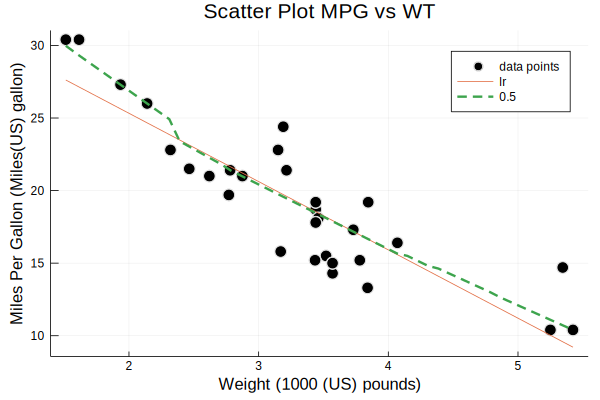

In [16]:
Plots.plot!(res05[1], res05[2], line = (3, :dash), label="0.5")

In [17]:
QuantileRegressions.qreg(fm, cars_df, .5)

StatsModels.TableRegressionModel{QuantileRegressions.QRegModel,Array{Float64,2}}

mpg ~ 1 + wt

Coefficients:
────────────────────────────────────────────────────
             Quantile  Estimate  Std.Error   t value
────────────────────────────────────────────────────
(Intercept)       0.5  33.8316    2.81723   12.0088
wt                0.5  -4.46316   0.821643  -5.43199
────────────────────────────────────────────────────

## Let's look at Quantiles [0.10, 0.25, 0.5, 0.75, 0.9]



In [18]:
Plots.plot(cars_df[!,:wt], cars_df[!,:mpg], seriestype = :scatter, label="data points",
            c= :black, markersize=8,
              title = "Scatter Plot MPG vs WT", 
              ylabel = "Miles Per Gallon (Miles(US) gallon)",
              xlabel = "Weight (1000 (US) pounds)",
              legend = true);

In [19]:
quantMPG_df = DataFrame()
for t = [0.10, 0.25, 0.5, 0.75]
    res = QuantileRegressions.npqreg(cars_df[!,:mpg], cars_df[!,:wt], t; h=2)
    quantMPG_df[!,Symbol("mpg_$t")] = res[2]
    Plots.plot!(res[1], res[2], line = (1, :dash), label="q=$t")
end

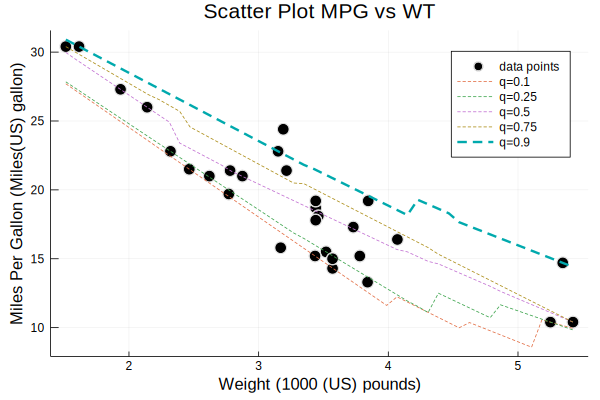

In [20]:
res = QuantileRegressions.npqreg(cars_df[!,:mpg], cars_df[!,:wt], 0.9; h=2)
quantMPG_df[!,Symbol("mpg_0.9")] = res[2]
Plots.plot!(res[1], res[2], line = (3, :dash), label="q=0.9")

# An even better plot

#### Code Borrowed from 

Need to use R for right now 


---